In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_error

from utils.model import hill_activation, hill_activation_single, hill_activation_and, random_search, hill_activation_ymin_ymax
from utils.helper import generate_data_at_t, generate_data_at_t_2, sum_squared_error, \
                       get_blank_corrected, get_neg_ctrl_corrected, get_pos_ctrl_corrected, \
                       generate_data, setup_header, read_map
from utils.plotter import plot_heatmap

In [2]:
folder = '033-all-and-gates-characterization'
#aras = [0, 0.8125, 3.25, 13, 52, 208]
#cumas = [0, 6.25, 12.5, 25, 50, 100]
#sample_dict = read_dict(pd.read_csv('datasets/dictionary.csv'))

In [3]:
aras = [0.011481536214968831, 1.0216094089843173, 5.683218062541121, 7.456853829419365, 7.579011602828942, 7.585426288573858]
cumas = [0.0014454397707459278, 0.0019057554535797324, 0.006249131232988513, 0.04999229196321327, 0.3736971000332177, 1.026212159295428]

In [ ]:
#aras = [1.7956771663999805e-24, 1.2688934711963533, 5.00205099555142, 7.602740484640011, 8.091909076913616, 8.152900352421902]
#cumas = [4.709616902401705e-21, 0.015098113289281526, 0.045151562877914546, 0.1306972994005621, 0.34667407758417, 0.7592114564531577]

In [ ]:
#aras = [0.03750366918249296, 1.2792226510560492, 4.876393351840785, 7.541874844548573, 8.110853849012505, 8.190364722728111]
#cumas = [0.05003142328119805, 0.05003142328144464, 0.05003142366781208, 0.050032029432179846, 0.05098144282831305, 1.012796957238742]

#### 24-hour measurement

In [4]:
actual_heatmaps = []
predicted_heatmaps = []
responses = []
for i in tqdm(range(1, 7)):
    ctrl_map = [(0, 2)] if i!=6 else [(0, 1)]
    samples_t = generate_data_at_t(folder, 'induction_matrix/plate{}'.format(i),
                                   '/induction_matrix/plate{}_map'.format(i),
                                   kind='2-input induction matrix', pos_ctrl_map=ctrl_map)[0]
    
    for gate in sorted(list(set(samples_t.index.str[:-3].tolist()))):
        
        fluo_t = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)].reset_index()
        fluo_t['cuma'] = fluo_t['name'].str[-2].astype(int)
        fluo_t['cuma'] = fluo_t['cuma'].apply(lambda x: cumas[x])
        fluo_t['ara'] = fluo_t['name'].str[-1].astype(int)
        fluo_t['ara'] = fluo_t['ara'].apply(lambda x: aras[x])
        
        x2, x1 = np.meshgrid(aras, cumas)
        x = np.vstack((x2.ravel(), x1.ravel()))
        y = np.abs(fluo_t['8 h '].values)
        gate_bounds = [[0, 0.01, 0, 0],
                       [1e4, 1e3, 1e2, 1e-1]]
        init_guess = random_search(50, x, y, gate_bounds, hill_activation_and)
        popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
        fluo_t['pred'] = hill_activation_and(x, *popt)
        
        sse = sum_squared_error(fluo_t['8 h '], fluo_t['pred'])
        
        responses.append((gate, fluo_t, sse, popt))
        
        actual = fluo_t[['8 h ', 'cuma', 'ara']].pivot('cuma', 'ara')
        actual.index = [np.round(cm, 3) for cm in cumas]
        actual.columns = [np.round(ar, 3) for ar in aras]
        actual_heatmaps.append((gate, actual))
        
        predicted = fluo_t[['pred', 'cuma', 'ara']].pivot('cuma', 'ara')
        predicted.index = [np.round(cm, 3) for cm in cumas]
        predicted.columns = [np.round(ar, 3) for ar in aras]
        predicted_heatmaps.append((gate, predicted))

  0%|                                                     | 0/6 [00:00<?, ?it/s]

[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]


 17%|███████▌                                     | 1/6 [00:00<00:04,  1.17it/s]

[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]


 33%|███████████████                              | 2/6 [00:01<00:03,  1.14it/s]

[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]


 50%|██████████████████████▌                      | 3/6 [00:02<00:02,  1.19it/s]

[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]


 67%|██████████████████████████████               | 4/6 [00:03<00:01,  1.17it/s]

[('A', 'sample'), ('A', 'positive'), ('B', 'positive')]


 83%|█████████████████████████████████████▌       | 5/6 [00:03<00:00,  1.37it/s]

[('A', 'sample'), ('B', 'positive')]


100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.24it/s]


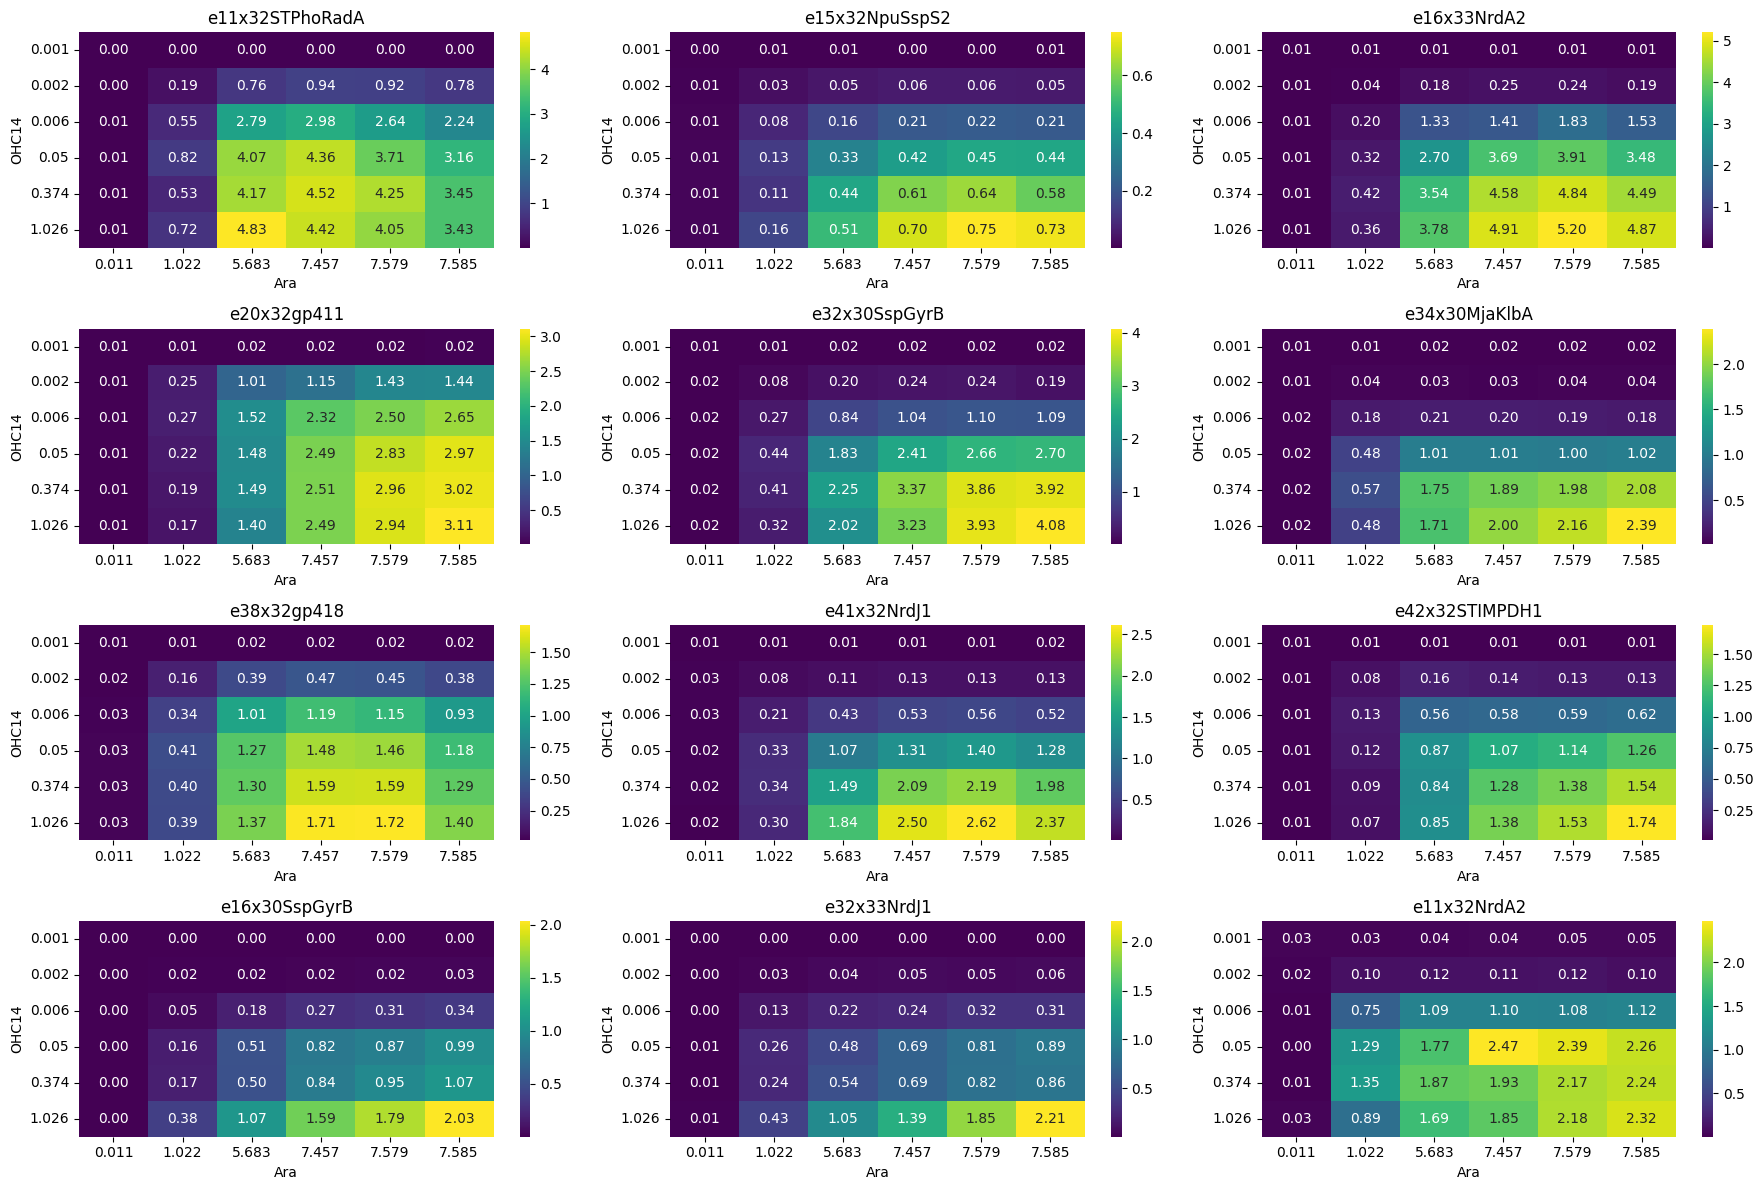

In [86]:
plot_heatmap(actual_heatmaps, 4, 3, 'Ara', 'OHC14', cmap='viridis')

In [ ]:
plot_heatmap(predicted_heatmaps, 4, 3, 'Ara', 'OHC14', cmap='viridis')

In [ ]:
actual_heatmaps = []
predicted_heatmaps = []
responses = []
h = 8
timepoint = 3 * h
rpu = True

for i in tqdm(range(1, 7)):
    
    raw_data = setup_header(pd.read_csv('datasets/experiment/{}/induction_matrix/plate{}.csv'.format(folder, i)))
    sample_map = read_map(pd.read_csv('datasets/experiment/{}/induction_matrix/plate{}_map.csv'.format(folder, i)),
                     sample_dict)
    
    group = 'A'
    contents = ['Sample', 'Blank', 'Negative control']
    all_datas = []
    for content in contents:
        datas = generate_data(raw_data[(raw_data['Group']==group) & (raw_data['Content'].str.startswith(content))],
                              sample_map, content, kind='2-input induction matrix')
        all_datas.append(datas)
        
    group = 'B'
    contents = ['Positive control', 'Blank', 'Negative control']
    all_ctrls = []
    for content in contents:
        datas = generate_data(raw_data[(raw_data['Group']==group) & (raw_data['Content'].str.startswith(content))],
                              sample_map, content, kind='2-input induction matrix')
        all_ctrls.append(datas)
        
    fluo_idx, od_idx = 3, 0
    if rpu:
        samples = get_pos_ctrl_corrected([all_datas[0][fluo_idx], all_datas[1][fluo_idx], all_datas[2][fluo_idx],
                                          all_datas[0][od_idx], all_datas[1][od_idx], all_datas[2][od_idx]],
                                         [all_ctrls[0][fluo_idx], all_ctrls[1][fluo_idx], all_ctrls[2][fluo_idx],
                                          all_ctrls[0][od_idx], all_ctrls[1][od_idx], all_ctrls[2][od_idx]])
    else:
        samples = get_neg_ctrl_corrected([all_datas[0][fluo_idx], all_datas[1][fluo_idx], all_datas[2][fluo_idx],
                                          all_datas[0][od_idx], all_datas[1][od_idx], all_datas[2][od_idx]])
    samples_t = samples.iloc[timepoint]
    
    for gate in sorted(list(set(samples_t.index.str[:-3].tolist()))):
        
        fluo_t = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)].reset_index()
        fluo_t['cuma'] = fluo_t['name'].str[-2].astype(int)
        fluo_t['cuma'] = fluo_t['cuma'].apply(lambda x: cumas[x])
        fluo_t['ara'] = fluo_t['name'].str[-1].astype(int)
        fluo_t['ara'] = fluo_t['ara'].apply(lambda x: aras[x])
        
        x2, x1 = np.meshgrid(aras, cumas)
        x = np.vstack((x2.ravel(), x1.ravel()))
        y = np.abs(fluo_t['8 h '].values)
        gate_bounds = [[0, 0.01, 0, 0],
                       [1e4, 1e3, 1e2, 1e-1]]
        init_guess = random_search(50, x, y, gate_bounds, hill_activation_and)
        popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
        fluo_t['pred'] = hill_activation_and(x, *popt)
        
        sse = sum_squared_error(fluo_t['8 h '], fluo_t['pred'])
        
        responses.append((gate, fluo_t, sse, popt))
        
        actual = fluo_t[['8 h ', 'cuma', 'ara']].pivot('cuma', 'ara')
        actual.index = [np.round(cm, 3) for cm in cumas]
        actual.columns = [np.round(ar, 3) for ar in aras]
        actual_heatmaps.append((gate, actual))
        
        predicted = fluo_t[['pred', 'cuma', 'ara']].pivot('cuma', 'ara')
        predicted.index = [np.round(cm, 3) for cm in cumas]
        predicted.columns = [np.round(ar, 3) for ar in aras]
        predicted_heatmaps.append((gate, predicted))

#### Single measurement

In [5]:
def build_plate_map(P1, P2):

    plate_map_builder = [[P1] * 6 + [P2] * 6 for _ in range(6)]
    plate_map_builder.append([np.NaN] * 12)
    plate_map_builder.append([np.NaN, np.NaN, 'BK', 'BK', '3K3-N', '3K3-N', 'BA', 'BA', '4A3-N', '4A3-N', '4A3-P', '4A3-P'])
    plate_map = pd.concat([pd.Series(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']),
               pd.DataFrame(np.array(plate_map_builder))], axis=1)
    plate_map.columns = ['group', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    
    return plate_map

In [7]:
gates_list = pd.read_csv('datasets/experiment/{}/plate_map.csv'.format(folder))
#heatmaps = []

for i in tqdm(range(len(gates_list))):
    
    P1, P2 = gates_list.iloc[i].tolist()
    a, b = str(i*2+1).zfill(3), str(i*2+2).zfill(3)
    
    samples_t = generate_data_at_t_2(folder, '{}-{}'.format(a, b),
                                   build_plate_map(P1, P2),
                                   kind='2-input induction matrix', pos_ctrl_map=[(0, 1)],
                                   single_timepoint=True)[0]
    
    for gate in sorted(list(set(samples_t.index.str[:-3].tolist()))):
        
        #fluo_t = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)].reset_index()
        #fluo_t['cuma'] = fluo_t['name'].str[-2]
        #fluo_t['ara'] = fluo_t['name'].str[-1]
        #responses.append((gate, fluo_t))
        
        #fluo_pvt = fluo_t.drop('name', axis=1).pivot('cuma', 'ara')
        #fluo_pvt.index = cumas
        #fluo_pvt.columns = aras
        #heatmaps.append((gate, fluo_pvt))
        
        try:
        
            fluo_t = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)].reset_index()
            fluo_t['cuma'] = fluo_t['name'].str[-2].astype(int)
            fluo_t['cuma'] = fluo_t['cuma'].apply(lambda x: cumas[x])
            fluo_t['ara'] = fluo_t['name'].str[-1].astype(int)
            fluo_t['ara'] = fluo_t['ara'].apply(lambda x: aras[x])

            x2, x1 = np.meshgrid(aras, cumas)
            x = np.vstack((x2.ravel(), x1.ravel()))
            y = np.abs(fluo_t[0].values)
            gate_bounds = [[0, 0.01, 0, 0],
                           [1e4, 1e3, 1e2, 1e-1]]
            init_guess = random_search(50, x, y, gate_bounds, hill_activation_and)
            popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
            fluo_t['pred'] = hill_activation_and(x, *popt)

            sse = sum_squared_error(fluo_t[0], fluo_t['pred'])

            responses.append((gate, fluo_t, sse, popt))

            actual = fluo_t[[0, 'cuma', 'ara']].pivot('cuma', 'ara')
            actual.index = [np.round(cm, 3) for cm in cumas]
            actual.columns = [np.round(ar, 3) for ar in aras]
            actual_heatmaps.append((gate, actual))

            predicted = fluo_t[['pred', 'cuma', 'ara']].pivot('cuma', 'ara')
            predicted.index = [np.round(cm, 3) for cm in cumas]
            predicted.columns = [np.round(ar, 3) for ar in aras]
            predicted_heatmaps.append((gate, predicted))
            
        except:
            
            print(gate)
            continue

 22%|█████████▍                                 | 12/55 [00:09<00:37,  1.14it/s]

e20x32M86


 40%|█████████████████▏                         | 22/55 [00:18<00:29,  1.14it/s]

e15x30CthTer


100%|███████████████████████████████████████████| 55/55 [00:46<00:00,  1.19it/s]


In [ ]:
gates_list = pd.read_csv('datasets/experiment/{}/plate_map.csv'.format(folder))
#heatmaps = []

for i in tqdm(range(len(gates_list))):
    
    P1, P2 = gates_list.iloc[i].tolist()
    a, b = str(i*2+1).zfill(3), str(i*2+2).zfill(3)
    
    raw_data = setup_header(pd.read_csv('datasets/experiment/{}/{}-{}.csv'.format(folder, a, b)))
    sample_map = read_map(build_plate_map(P1, P2), sample_dict)
    
    group = 'A'
    contents = ['Sample', 'Blank', 'Negative control']
    all_datas = []
    for content in contents:
        datas = generate_data(raw_data[(raw_data['Group']==group) & (raw_data['Content'].str.startswith(content))],
                              sample_map, content, kind='2-input induction matrix')
        all_datas.append(datas)
        
    group = 'B'
    contents = ['Positive control', 'Blank', 'Negative control']
    all_ctrls = []
    for content in contents:
        datas = generate_data(raw_data[(raw_data['Group']==group) & (raw_data['Content'].str.startswith(content))],
                              sample_map, content, kind='2-input induction matrix')
        all_ctrls.append(datas)
        
    fluo_idx, od_idx = 3, 0
    if rpu:
        samples = get_pos_ctrl_corrected([all_datas[0][fluo_idx], all_datas[1][fluo_idx], all_datas[2][fluo_idx],
                                          all_datas[0][od_idx], all_datas[1][od_idx], all_datas[2][od_idx]],
                                         [all_ctrls[0][fluo_idx], all_ctrls[1][fluo_idx], all_ctrls[2][fluo_idx],
                                          all_ctrls[0][od_idx], all_ctrls[1][od_idx], all_ctrls[2][od_idx]])
    else:
        samples = get_neg_ctrl_corrected([all_datas[0][fluo_idx], all_datas[1][fluo_idx], all_datas[2][fluo_idx],
                                          all_datas[0][od_idx], all_datas[1][od_idx], all_datas[2][od_idx]])
    samples_t = samples.mean() #average of multiple timepoints
    
    for gate in sorted(list(set(samples_t.index.str[:-3].tolist()))):
        
        #fluo_t = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)].reset_index()
        #fluo_t['cuma'] = fluo_t['name'].str[-2]
        #fluo_t['ara'] = fluo_t['name'].str[-1]
        #responses.append((gate, fluo_t))
        
        #fluo_pvt = fluo_t.drop('name', axis=1).pivot('cuma', 'ara')
        #fluo_pvt.index = cumas
        #fluo_pvt.columns = aras
        #heatmaps.append((gate, fluo_pvt))
        
        try:
        
            fluo_t = samples_t[filter(lambda x: x.startswith(gate), samples_t.index)].reset_index()
            fluo_t['cuma'] = fluo_t['name'].str[-2].astype(int)
            fluo_t['cuma'] = fluo_t['cuma'].apply(lambda x: cumas[x])
            fluo_t['ara'] = fluo_t['name'].str[-1].astype(int)
            fluo_t['ara'] = fluo_t['ara'].apply(lambda x: aras[x])

            x2, x1 = np.meshgrid(aras, cumas)
            x = np.vstack((x2.ravel(), x1.ravel()))
            y = np.abs(fluo_t[0].values)
            gate_bounds = [[0, 0.01, 0, 0],
                           [1e4, 1e3, 1e2, 1e-1]]
            init_guess = random_search(50, x, y, gate_bounds, hill_activation_and)
            popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)
            fluo_t['pred'] = hill_activation_and(x, *popt)

            sse = sum_squared_error(fluo_t[0], fluo_t['pred'])

            responses.append((gate, fluo_t, sse, popt))

            actual = fluo_t[[0, 'cuma', 'ara']].pivot('cuma', 'ara')
            actual.index = [np.round(cm, 3) for cm in cumas]
            actual.columns = [np.round(ar, 3) for ar in aras]
            actual_heatmaps.append((gate, actual))

            predicted = fluo_t[['pred', 'cuma', 'ara']].pivot('cuma', 'ara')
            predicted.index = [np.round(cm, 3) for cm in cumas]
            predicted.columns = [np.round(ar, 3) for ar in aras]
            predicted_heatmaps.append((gate, predicted))
            
        except:
            
            print(gate)
            continue

In [76]:
sorted_resp[0]

('e15x30TvoVMA',
                name         0      cuma       ara      pred
 0   e15x30TvoVMA_00  0.003147  0.001445  0.011482  0.001992
 1   e15x30TvoVMA_01  0.002558  0.001445  1.021609  0.001992
 2   e15x30TvoVMA_02  0.002591  0.001445  5.683218  0.001992
 3   e15x30TvoVMA_03  0.002656  0.001445  7.456854  0.001992
 4   e15x30TvoVMA_04  0.001966  0.001445  7.579012  0.001992
 5   e15x30TvoVMA_05  0.002460  0.001445  7.585426  0.001992
 6   e15x30TvoVMA_10  0.002652  0.001906  0.011482  0.001992
 7   e15x30TvoVMA_11  0.002101  0.001906  1.021609  0.001992
 8   e15x30TvoVMA_12  0.002167  0.001906  5.683218  0.001992
 9   e15x30TvoVMA_13  0.001594  0.001906  7.456854  0.001992
 10  e15x30TvoVMA_14  0.001734  0.001906  7.579012  0.001992
 11  e15x30TvoVMA_15  0.002362  0.001906  7.585426  0.001992
 12  e15x30TvoVMA_20  0.001861  0.006249  0.011482  0.001992
 13  e15x30TvoVMA_21  0.002265  0.006249  1.021609  0.001992
 14  e15x30TvoVMA_22  0.001770  0.006249  5.683218  0.001992
 15  e1

In [42]:
sorted_resp = sorted(responses, key=lambda x: x[2])
selection = [i[0] for i in sorted_resp if i[1].iloc[:,1].max() > 1.0][:12]

In [89]:
dictionary = pd.read_csv('datasets/dictionary.csv')
dictionary.head()

,id,short_name,full_name
0,A1,e11x32M86,3K3-P11*-gfp-B15-P(ara)-sECF11*-SP1-P(Cym)-32-...
1,A2,e11x30STNpuSspS2,3K3-P11*-gfp-B15-P(ara)-sECF11*-SP2-P(Cym)-30-...
2,A3,e11x32NpuSspS2,3K3-P11*-gfp-B15-P(ara)-sECF11*-SP2-P(Cym)-32-...
3,A4,e11x30NpuSspS1,3K3-P11*-gfp-B15-P(ara)-sECF11*-SP2-P(Cym)-30-...
4,A5,e11x32gp411,3K3-P11*-gfp-B15-P(ara)-sECF11*-SP3-P(Cym)-32-...


In [90]:
dictionary[dictionary['short_name'].isin(selection)]

,id,short_name,full_name
23,A24,e11x33NrdA2,3K3-P11*-gfp-B15-P(ara)-sECF11*-SP31-P(Cym)-33...
69,A70,e16x32STPhoRadA,3K3-P16*-gfp-B15-P(ara)-sECF16*-SP11-P(Cym)-32...
89,A87,e17x33NrdJ1,3K3-P17*-gfp-B15-P(ara)-sECF17*-SP5-P(Cym)-33-...
99,A95,e17x30STPhoRadA,3K3-P17*-gfp-B15-P(ara)-sECF17*-SP11-P(Cym)-30...
100,A96,e17x32STPhoRadA,3K3-P17*-gfp-B15-P(ara)-sECF17*-SP11-P(Cym)-32...
101,A97,e17x30CthTer,3K3-P17*-gfp-B15-P(ara)-sECF17*-SP20-P(Cym)-30...
149,A143,e22x30SspGyrB,3K3-P22*-gfp-B15-P(ara)-sECF22*-SP8-P(Cym)-30-...
155,A148,e22x32STPhoRadA,3K3-P22*-gfp-B15-P(ara)-sECF22*-SP11-P(Cym)-32...
198,A191,e32x33NrdJ1,3K3-P32*-gfp-B15-P(ara)-sECF32*-SP5-P(Cym)-33-...
268,A261,e38x32M86,3K3-P38*-gfp-B15-P(ara)-sECF38*-SP1-P(Cym)-32-...


In [85]:
temp_arr = []
temp_col = []
for g in [i for i in sorted_resp if i[1].iloc[:,1].max() > 1.5][:12]:
    
    temp_col.append(g[0])
    temp_arr.append(pd.DataFrame(g[1][0]))

selected_df = pd.concat(temp_arr, axis=1)
selected_df.columns = temp_col
selected_df.to_csv('datasets/selected_low_error_gates.csv', index=False)

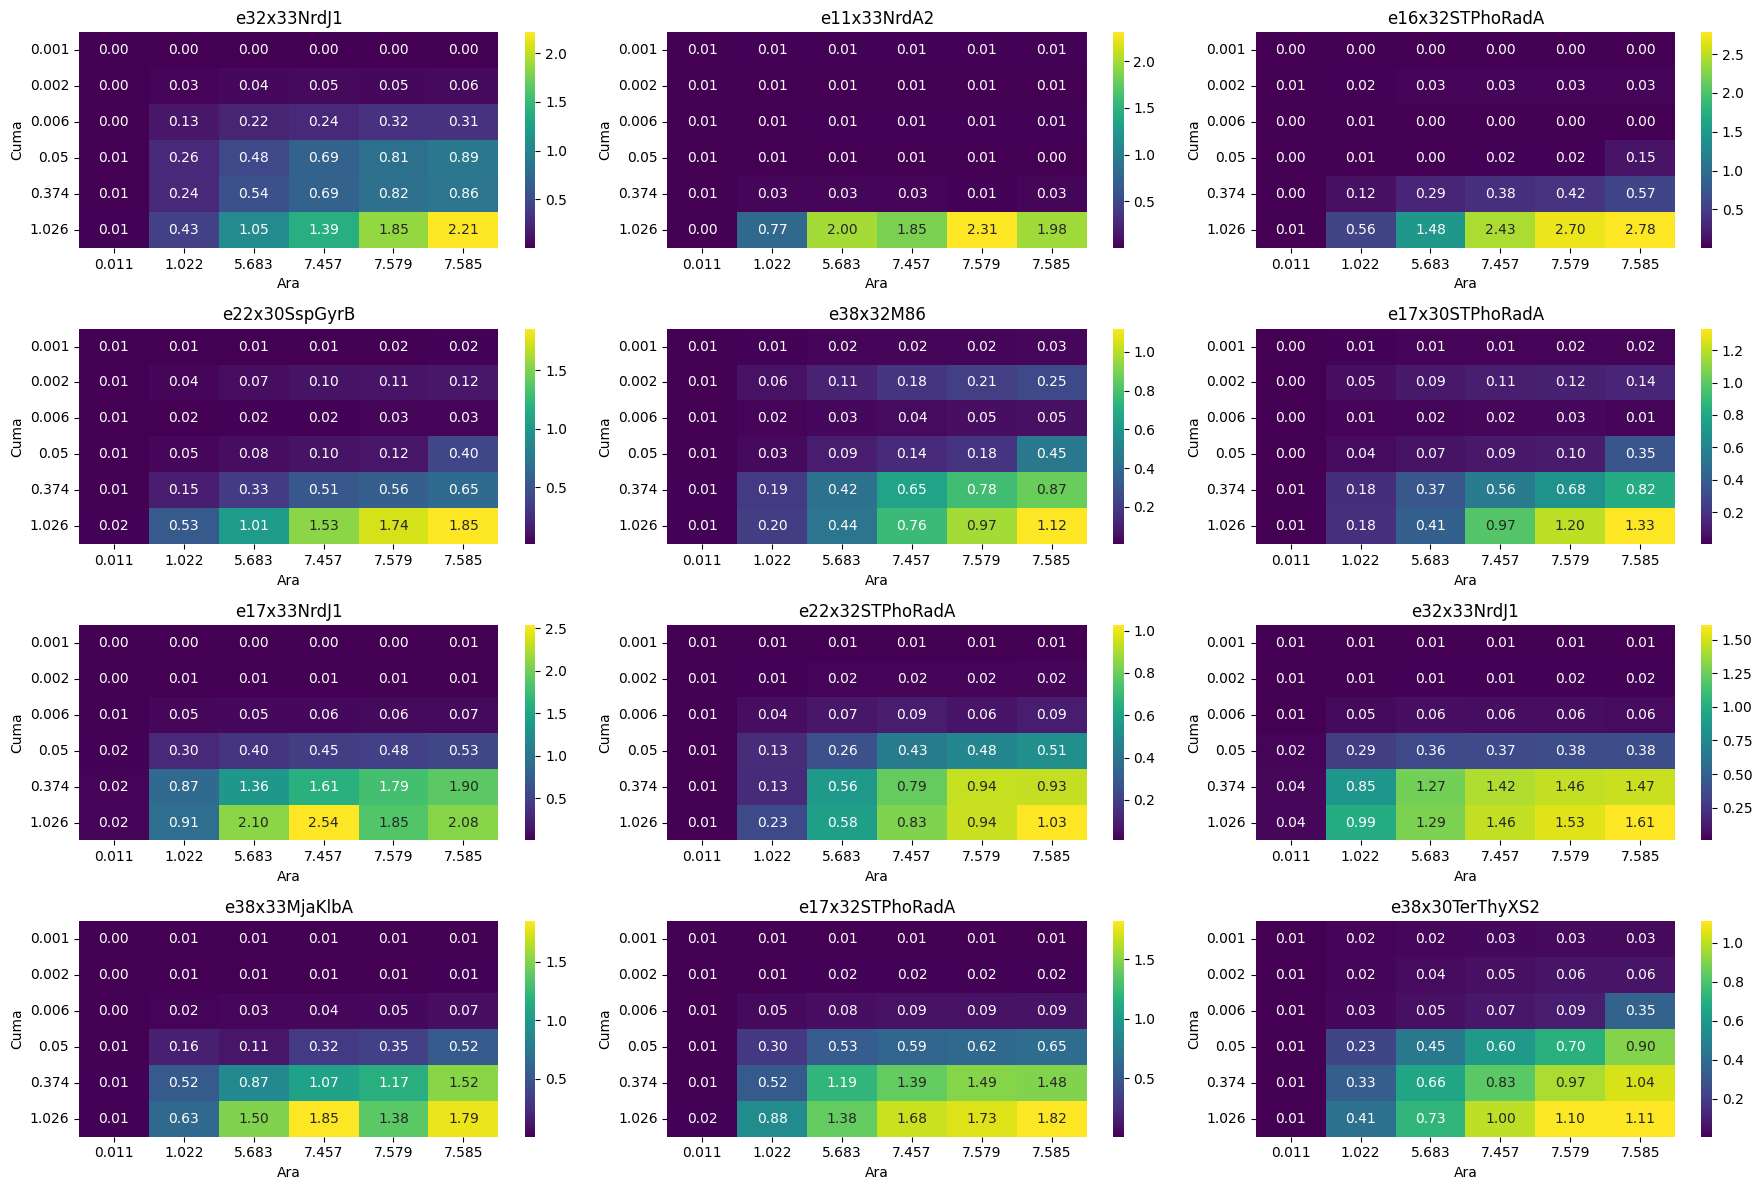

In [46]:
best_act = [i for i in actual_heatmaps if i[0] in selection]
plot_heatmap(best_act, 4, 3, 'Ara', 'Cuma', cmap='viridis')

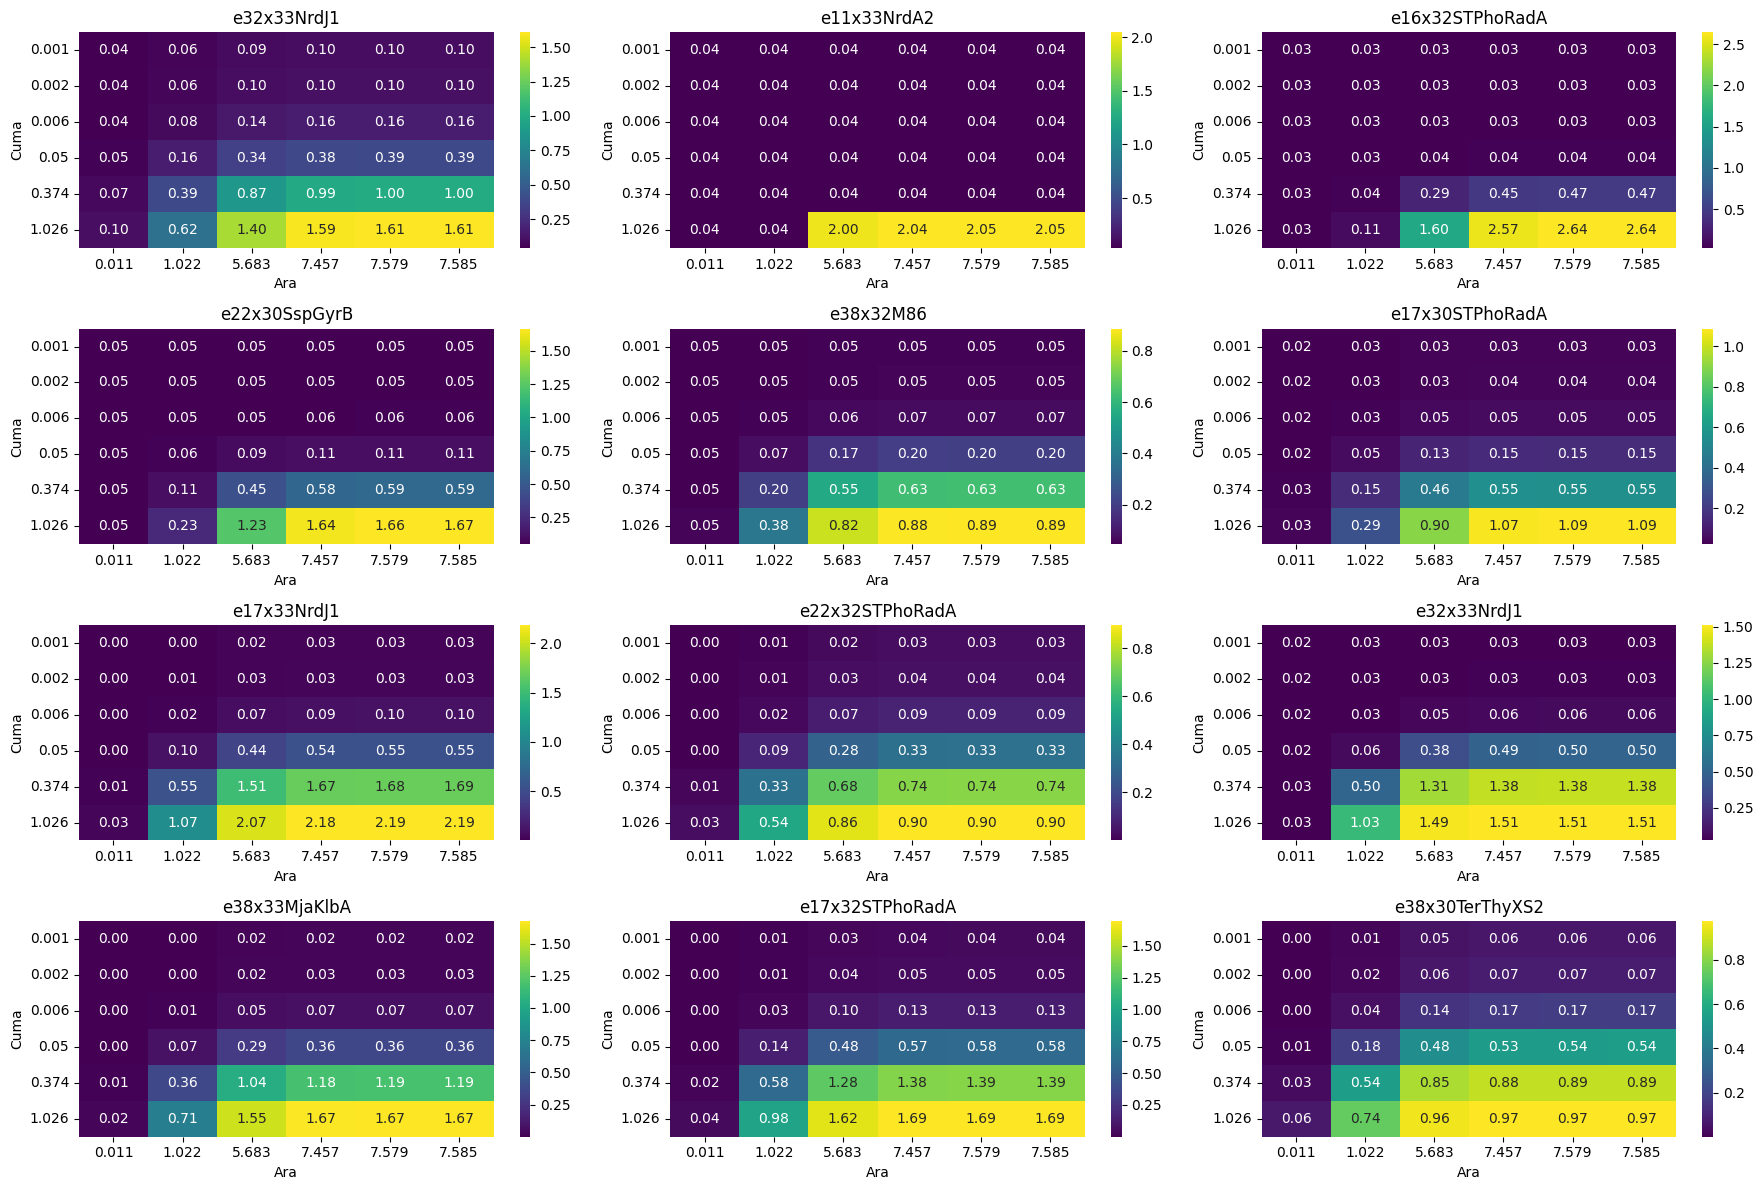

In [47]:
best_pred = [i for i in predicted_heatmaps if i[0] in selection]
plot_heatmap(best_pred, 4, 3, 'Ara', 'Cuma', cmap='viridis')

In [75]:
best_pred[0]

('e32x33NrdJ1',
           0.011     1.022     5.683     7.457     7.579     7.585
 0.001  0.042151  0.060005  0.088366  0.095636  0.096104  0.096128
 0.002  0.042448  0.063055  0.095775  0.104160  0.104700  0.104728
 0.006  0.044344  0.082473  0.142888  0.158345  0.159340  0.159392
 0.050  0.052341  0.164068  0.339500  0.384072  0.386937  0.387086
 0.374  0.074611  0.388280  0.868745  0.988535  0.996203  0.996604
 1.026  0.098251  0.621582  1.402899  1.593983  1.606164  1.606801)

In [55]:
i = 8
print(best_pred[0][0])
actual, training = best_act[i][1], best_pred[i][1]

e32x33NrdJ1


In [52]:
colors = ['#cc0000', '#00cc00', '#0000cc', '#cccc00', '#cc00cc', '#00cccc']

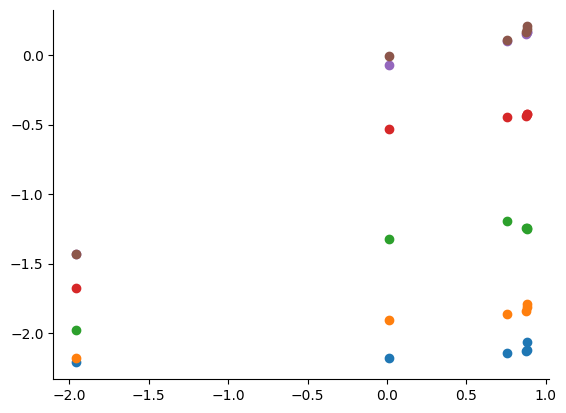

In [119]:
for i in range(len(actual)):
    plt.scatter(np.log10(actual.columns), np.log10(actual.iloc[i, :]))
#plt.loglog()
sns.despine()

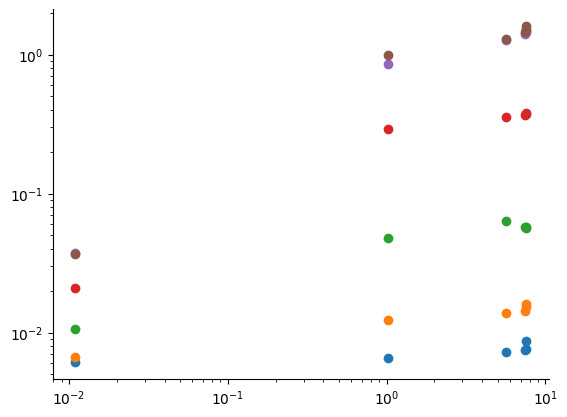

In [118]:
for i in range(len(actual)):
    plt.scatter(actual.columns, actual.iloc[i, :])
    #plt.plot(training.columns, training.iloc[i, :])
#plt.xscale('log', base=2)
plt.loglog()
sns.despine()

[1.09193017e+00 3.97793942e-01 8.75892371e-01 2.02354594e-39]


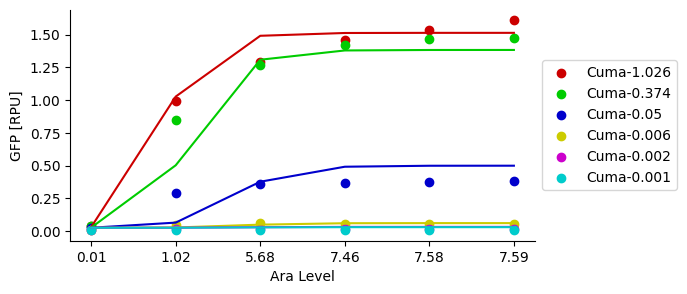

In [53]:
plt.figure(figsize=[6, 3])
print(popt)
plt.scatter(np.arange(actual.shape[1]), actual.iloc[5, :], color=colors[0], label='Cuma-{}'.format(np.round(cumas[5], 3)))
plt.scatter(np.arange(actual.shape[1]), actual.iloc[4, :], color=colors[1], label='Cuma-{}'.format(np.round(cumas[4], 3)))
plt.scatter(np.arange(actual.shape[1]), actual.iloc[3, :], color=colors[2], label='Cuma-{}'.format(np.round(cumas[3], 3)))
plt.scatter(np.arange(actual.shape[1]), actual.iloc[2, :], color=colors[3], label='Cuma-{}'.format(np.round(cumas[2], 3)))
plt.scatter(np.arange(actual.shape[1]), actual.iloc[1, :], color=colors[4], label='Cuma-{}'.format(np.round(cumas[1], 3)))
plt.scatter(np.arange(actual.shape[1]), actual.iloc[0, :], color=colors[5], label='Cuma-{}'.format(np.round(cumas[0], 3)))

plt.plot(np.arange(training.shape[1]), training.iloc[5, :], color=colors[0])
plt.plot(np.arange(training.shape[1]), training.iloc[4, :], color=colors[1])
plt.plot(np.arange(training.shape[1]), training.iloc[3, :], color=colors[2])
plt.plot(np.arange(training.shape[1]), training.iloc[2, :], color=colors[3])
plt.plot(np.arange(training.shape[1]), training.iloc[1, :], color=colors[4])
plt.plot(np.arange(training.shape[1]), training.iloc[0, :], color=colors[5])
#plt.loglog()
#plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('GFP [RPU]')
plt.xlabel('Ara Level')
plt.xticks(np.arange(len(aras)), labels=[np.round(i, 2) for i in aras])
sns.despine()

[1.09193017e+00 3.97793942e-01 8.75892371e-01 2.02354594e-39]


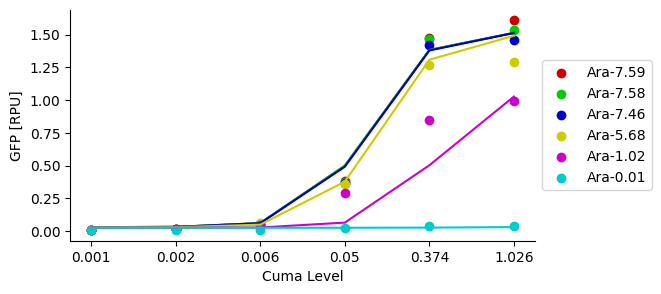

In [54]:
plt.figure(figsize=[6, 3])
print(popt)

plt.scatter(np.arange(actual.shape[0]), actual.iloc[:, 5], color=colors[0], label='Ara-{}'.format(np.round(aras[5], 2)))
plt.scatter(np.arange(actual.shape[0]), actual.iloc[:, 4], color=colors[1], label='Ara-{}'.format(np.round(aras[4], 2)))
plt.scatter(np.arange(actual.shape[0]), actual.iloc[:, 3], color=colors[2], label='Ara-{}'.format(np.round(aras[3], 2)))
plt.scatter(np.arange(actual.shape[0]), actual.iloc[:, 2], color=colors[3], label='Ara-{}'.format(np.round(aras[2], 2)))
plt.scatter(np.arange(actual.shape[0]), actual.iloc[:, 1], color=colors[4], label='Ara-{}'.format(np.round(aras[1], 2)))
plt.scatter(np.arange(actual.shape[0]), actual.iloc[:, 0], color=colors[5], label='Ara-{}'.format(np.round(aras[0], 2)))

plt.plot(np.arange(training.shape[0]), training.iloc[:, 5], color=colors[0])
plt.plot(np.arange(training.shape[0]), training.iloc[:, 4], color=colors[1])
plt.plot(np.arange(training.shape[0]), training.iloc[:, 3], color=colors[2])
plt.plot(np.arange(training.shape[0]), training.iloc[:, 2], color=colors[3])
plt.plot(np.arange(training.shape[0]), training.iloc[:, 1], color=colors[4])
plt.plot(np.arange(training.shape[0]), training.iloc[:, 0], color=colors[5])
#plt.loglog()
#plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('GFP [RPU]')
plt.xlabel('Cuma Level')
plt.xticks(np.arange(len(cumas)), labels=[np.round(i, 3) for i in cumas])
sns.despine()

In [ ]:
arr_ind1 = np.arange(0.05, np.max(cumas), 0.05)
arr_ind2 = np.arange(0.01, np.max(aras), 0.01)
x2_, x1_ = np.meshgrid(arr_ind2, cumas)
x_ = np.vstack((x2_.ravel(), x1_.ravel()))
y_ = hill_activation_and(x_, *popt)

In [ ]:
df = pd.DataFrame(x_.T)
df['y'] = y_
training2 = df.pivot(1, 0)
training2.index = cumas
training2.columns = arr_ind2

In [ ]:
plt.scatter(actual.columns, actual.iloc[5, :], color='orange')
plt.scatter(actual.columns, actual.iloc[4, :], color='green')
plt.scatter(actual.columns, actual.iloc[3, :], color='red')
plt.scatter(actual.columns, actual.iloc[2, :], color='purple')

plt.plot(training.columns, training.iloc[5, :], color='orange')
plt.plot(training.columns, training.iloc[4, :], color='green')
plt.plot(training.columns, training.iloc[3, :], color='red')
plt.plot(training.columns, training.iloc[2, :], color='purple')
#plt.loglog()
plt.xscale('log')
sns.despine()

In [ ]:
plt.scatter(actual.columns, actual.iloc[5, :], color='orange')
plt.scatter(actual.columns, actual.iloc[4, :], color='green')
plt.scatter(actual.columns, actual.iloc[3, :], color='red')
plt.scatter(actual.columns, actual.iloc[2, :], color='purple')

plt.plot(training2.columns, training2.iloc[5, :], color='orange')
plt.plot(training2.columns, training2.iloc[4, :], color='green')
plt.plot(training2.columns, training2.iloc[3, :], color='red')
plt.plot(training2.columns, training2.iloc[2, :], color='purple')
#plt.loglog()
plt.xscale('log')
sns.despine()

In [ ]:
plt.scatter(np.arange(actual.shape[0]), actual.iloc[:, 5], color='orange')
plt.scatter(np.arange(actual.shape[0]), actual.iloc[:, 4], color='green')
plt.scatter(np.arange(actual.shape[0]), actual.iloc[:, 3], color='red')
plt.scatter(np.arange(actual.shape[0]), actual.iloc[:, 2], color='purple')
plt.scatter(np.arange(actual.shape[0]), actual.iloc[:, 1], color='blue')
plt.scatter(np.arange(actual.shape[0]), actual.iloc[:, 0], color='brown')

plt.plot(np.arange(training.shape[0]), training.iloc[:, 5], color='orange')
plt.plot(np.arange(training.shape[0]), training.iloc[:, 4], color='green')
plt.plot(np.arange(training.shape[0]), training.iloc[:, 3], color='red')
plt.plot(np.arange(training.shape[0]), training.iloc[:, 2], color='purple')
plt.plot(np.arange(training.shape[0]), training.iloc[:, 1], color='blue')
plt.plot(np.arange(training.shape[0]), training.iloc[:, 0], color='brown')
#plt.loglog()
#plt.yscale('log')
sns.despine()

In [ ]:
data = [i[1] for i in responses if i[0] in selection][0]
data

In [ ]:
plt.figure(figsize=[10, 6])
data = data[['name', '8 h ', 'pred']].rename(columns={'8 h ': 'actual', 'pred': 'training'}).melt(id_vars='name')
sns.barplot(x='name', y='value', hue='variable', data=data)
plt.xlabel('Induction states')
plt.xticks(rotation=90)
plt.ylabel('RPU')
#plt.yscale('log')
sns.despine()

In [ ]:
heatmaps_ = sorted(heatmaps, key=lambda x: x[0])
responses_ = sorted(responses, key=lambda x: x[0])

In [ ]:
sorted(list(set([i[0][6:] for i in heatmaps])))

In [ ]:
def plot_decompose_cuma(datas, row, col):
    
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(datas):
            data = datas[i][1]
            cuma_lvl = data['cuma'].unique()
            for cuma in cuma_lvl:
                selection = data[data['cuma']==cuma].reset_index(drop=True)
                ax.plot(selection.index, selection.iloc[:,1], marker='o', label=cuma)
                ax.set_xlabel('Ara')
                ax.set_ylabel('Fluo/OD')
                ax.set_title(datas[i][0])
            ax.legend(loc=4)
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()
    
def plot_decompose_ara(datas, row, col):
    
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(datas):
            data = datas[i][1]
            ara_lvl = data['ara'].unique()
            for ara in ara_lvl:
                selection = data[data['ara']==ara].reset_index(drop=True)
                ax.plot(selection.index, selection.iloc[:,1], marker='o', label=ara)
                ax.set_xlabel('Cuma')
                ax.set_ylabel('Fluo/OD')
                ax.set_title(datas[i][0])
            ax.legend(loc=4)
        else:
            ax.set_visible(False)
    plt.tight_layout()
    plt.show()

In [ ]:
responses_[0][0][4:6]

In [ ]:
filtered_resp = [i for i in responses_ if i[0][4:6]=='32' and i[1].iloc[:, 1].max()>2]
len(filtered_resp)

In [ ]:
filtered_resp

In [ ]:
plot_decompose_cuma(filtered_resp[0:16], 4, 4)

In [ ]:
plot_decompose_cuma(filtered_resp[16:32], 4, 4)

In [ ]:
plot_decompose_cuma(filtered_resp[32:48], 4, 4)

In [ ]:
plot_decompose_cuma(filtered_resp[16:32], 4, 4)

In [ ]:
plot_decompose_ara(filtered_resp[0:16], 4, 4)

In [ ]:
plot_decompose_ara(filtered_resp[16:32], 4, 4)

In [ ]:
plot_decompose_ara(filtered_resp[32:48], 4, 4)

#### Checking Training Performance

In [ ]:
hill_params= []
ys = []
colormeshes = []

for i in tqdm(range(len(heatmaps))):
    
    fluo = heatmaps[i][1]
    fluo = fluo.reset_index().melt('index', var_name='ara', value_name='fluo')
    fluo.rename(columns={'index': 'cuma'}, inplace=True)

    x1, x2 = np.meshgrid(cumas, aras)
    x = np.vstack((x1.ravel(), x2.ravel()))
    y = np.abs(fluo['fluo'].values)
    
    gate_bounds = [[0, 0, 0, 0, 0, 0, 0, 0],
                   [1e3, 1e3, 4, 4, y.min()+0.1, y.min()+0.1, y.max()+0.5*y.max(), y.max()+0.5*y.max()]]
    
    try:
        init_guess = random_search(30, x, y, gate_bounds, hill_activation_and)
        popt, pcov = curve_fit(hill_activation_and, x, y, p0=init_guess, bounds=gate_bounds)

        y_pred = hill_activation_and(x, *popt)
        hill_params.append((heatmaps[i][0], *popt))

        ys.append((heatmaps[i][0], y, y_pred))

        arr_ind1 = np.arange(0, 2.5, 0.005)
        arr_ind2 = np.arange(0, 10, 0.05)
        x1_, x2_ = np.meshgrid(arr_ind1, arr_ind2)
        x_ = np.vstack((x1_.ravel(), x2_.ravel()))
        y_pred_ = hill_activation_and(x_, *popt)

        colormeshes.append((x2_, x1_, y_pred_, len(arr_ind1), heatmaps[i][0]))
        
    except:
        print('error at ', heatmaps[i][0])
        continue

In [ ]:
ys[0]

In [ ]:
filtered = [(y[0], mean_absolute_error(y[1], y[2]), max(y[1])) for y in ys if max(y[1])>2]
sorted(filtered, key=lambda x: x[1])

In [ ]:
r2s = []

In [ ]:
f, axs = plt.subplots(1, 8, sharex=False, sharey=False, figsize=(16, 2))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(r2s):
        y = r2s[i]
        sns.regplot(y[1], y[2], ax=ax, label='R2={}'.format(round(r2_score(y[1], y[2]), 2)))
        ax.set_title(y[0])
        ax.set_xlabel('Experiment')
        ax.set_ylabel('Predicted')
        ax.legend(loc=4)
        sns.despine()
    else:
        ax.set_visible(False)
plt.tight_layout()